In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('pd_speech_features.csv',skiprows=[0])
df.head()

id  gender      PPE      DFA     RPDE  numPulses  numPeriodsPulses  \
0   0       1  0.85247  0.71826  0.57227        240               239   
1   0       1  0.76686  0.69481  0.53966        234               233   
2   0       1  0.85083  0.67604  0.58982        232               231   
3   1       0  0.41121  0.79672  0.59257        178               177   
4   1       0  0.32790  0.79782  0.53028        236               235   

   meanPeriodPulses  stdDevPeriodPulses  locPctJitter  ...  \
0          0.008064            0.000087       0.00218  ...   
1          0.008258            0.000073       0.00195  ...   
2          0.008340            0.000060       0.00176  ...   
3          0.010858            0.000183       0.00419  ...   
4          0.008162            0.002669       0.00535  ...   

   tqwt_kurtosisValue_dec_28  tqwt_kurtosisValue_dec_29  \
0                     1.5620                     2.6445   
1                     1.5589                     3.6107   
2                     1.5643                     2.3308   
3                     3.7805                     3.5664   
4                     6.1727                     5.8416   

   tqwt_kurtosisValue_dec_30  tqwt_kurtosisValue_dec_31  \
0                     3.8686                     4.2105   
1                    23.5155                    14.1962   
2                     9.4959                    10.7458   
3                     5.2558                    14.0403   
4                     6.0805                     5.7621   

   tqwt_kurtosisValue_dec_32  tqwt_kurtosisValue_dec_33  \
0                     5.1221                     4.4625   
1                    11.0261                     9.5082   
2                    11.0177                     4.8066   
3                     4.2235                     4.6857   
4                     7.7817                    11.6891   

   tqwt_kurtosisValue_dec_34  tqwt_kurtosisValue_dec_35  \
0                     2.6202                     3.0004   
1                     6.5245                     6.3431   
2                     2.9199                     3.1495   
3                     4.8460                     6.2650   
4                     8.2103                     5.0559   

   tqwt_kurtosisValue_dec_36  class  
0                    18.9405      1  
1                    45.1780      1  
2                     4.7666      1  
3                     4.0603      1  
4                     6.1164      1  

[5 rows x 755 columns]

In [3]:
corr = df.corr()
corr['class'].sort_values(ascending=False)

class                          1.000000
mean_MFCC_2nd_coef             0.398695
tqwt_minValue_dec_12           0.395740
tqwt_minValue_dec_11           0.366552
tqwt_minValue_dec_13           0.365264
std_9th_delta_delta            0.364333
std_8th_delta_delta            0.364256
std_7th_delta_delta            0.354239
std_6th_delta_delta            0.349046
std_8th_delta                  0.342875
std_10th_delta_delta           0.335408
std_9th_delta                  0.335396
std_11th_delta_delta           0.335358
std_6th_delta                  0.323126
std_7th_delta                  0.319825
std_delta_delta_log_energy     0.318687
tqwt_minValue_dec_14           0.314564
std_10th_delta                 0.311160
std_11th_delta                 0.311008
DFA                            0.306070
std_12th_delta_delta           0.304516
tqwt_minValue_dec_10           0.297256
app_entropy_shannon_10_coef    0.292445
app_entropy_shannon_9_coef     0.292408
app_entropy_shannon_8_coef     0.292383


In [4]:
X =df.iloc[:,:-1]
y = df.iloc[:,-1:]
# y.reshape(-1,1)

In [5]:
from sklearn.feature_selection import SelectKBest,chi2,f_classif
X_new = SelectKBest(f_classif,k=700).fit_transform(X, y)

/home/goodwillhunting/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
X_new.shape

(756, 700)

In [7]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X_new)
# y = ss.fit_transform(y)

# TensorFlow linear regression

In [8]:
import tensorflow as tf
tf.set_random_seed(42)

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [10]:
num_outputs,num_inputs = y_train.shape[1],X_train.shape[1]

y_tensor = tf.placeholder(tf.float32,shape=[None,num_outputs],name='y')
x_tensor = tf.placeholder(tf.float32,shape=[None,num_inputs],name='x')

w = tf.Variable(tf.zeros([num_inputs,num_outputs]),name='w')
b = tf.Variable(tf.zeros([num_outputs]),name='b')

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model = tf.add(tf.matmul(x_tensor,w),b)

In [12]:
loss = tf.reduce_mean(tf.square(model-y_tensor))
mse = tf.reduce_mean(tf.square(model-y_tensor))
y_mean = tf.reduce_mean(y_tensor)
sst = tf.reduce_sum(tf.square(y_tensor-y_mean))
sse = tf.reduce_sum(tf.square(y_tensor-model))
rs = tf.subtract(1.,tf.truediv(sse,sst))

In [13]:
lr = 0.01
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)

In [14]:
w_hat,b_hat=0,0
loss_epochs,mse_epochs,rs_epochs=[],[],[]
with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for i in range(1500):
#         optimize the training data
        feed_dict = {x_tensor:X_train,y_tensor:y_train}
        lsv,_ = tfs.run([loss,optimizer],feed_dict=feed_dict)
        loss_epochs.append(lsv)
        
#         optimize the test data
        feed_dict = {x_tensor:X_test,y_tensor:y_test}
        msv,rsv = tfs.run([mse,rs],feed_dict=feed_dict)
        mse_epochs.append(msv)
        rs_epochs.append(rsv)
        
    w_hat,b_hat = tfs.run([w,b])
#     w_hat.reshape(-1) 

In [15]:
import matplotlib.pyplot as plt

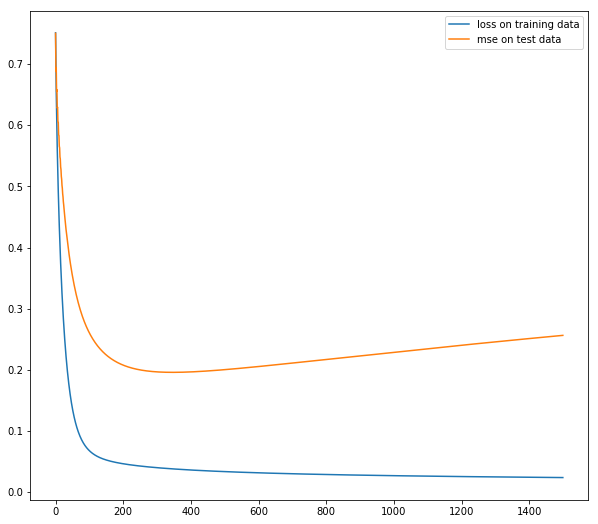

In [16]:
plt.figure(figsize=(10,9))
plt.plot(loss_epochs,label="loss on training data")
plt.plot(mse_epochs,label="mse on test data")
plt.legend()
plt.show();

In [17]:
plt.figure(figsize=(10,9))
plt.plot(rs_epochs,label="R$^2")

plt.legend()
plt.show();

In [18]:
print("MSE: {}\nR-Squared: {}\nRMSE: {}".format(mse_epochs[-1],rs_epochs[-1],np.sqrt(mse_epochs[-1])))

MSE: 0.2563890218734741
R-Squared: -0.30128908157348633
RMSE: 0.506348729133606
